In [10]:
import pandas as pd
import numpy as np
df = pd.read_csv('./preprocess/filter3.csv')

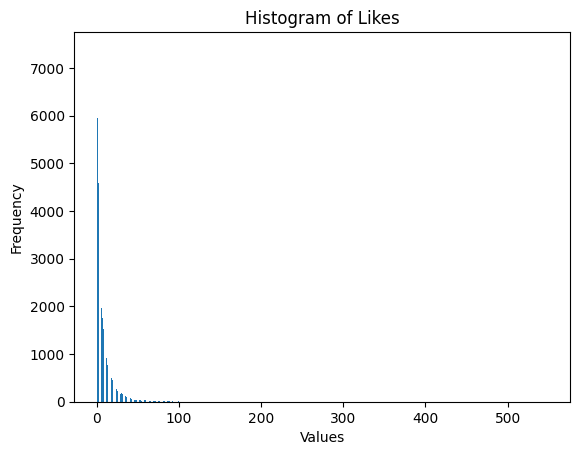

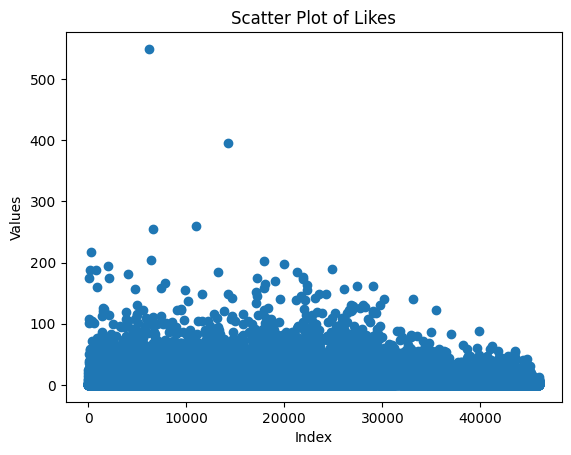

In [11]:
import matplotlib.pyplot as plt

# Plot histogram of Column2
plt.hist(df['Likes'], bins='auto')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Likes')
plt.show()

# Create scatter plot of Column2
plt.scatter(range(len(df['Likes'])), df['Likes'])
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Scatter Plot of Likes')
plt.show()

Text(0.5, 1.0, 'No. of words in Title')

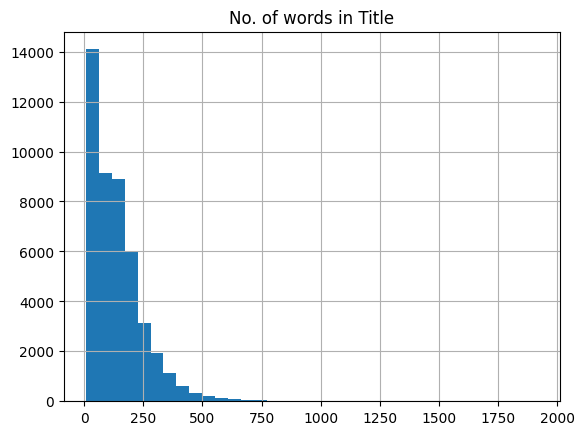

In [12]:
df['qLen'] = df['Message'].apply(lambda x : len(x.split(" ")))
df['qLen'].hist(bins=35)
plt.title("No. of words in Message")

In [5]:
import torch
from transformers import AutoModel, AutoTokenizer

# model_name = 'distilbert-base-uncased'
model_name = 'vinai/phobert-base-v2'

phobert = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

In [6]:
keyword = "Thủ tướng: Thúc đẩy hợp tác trong lĩnh vực Việt Nam có lợi ích chiến lược"
tokens = tokenizer.tokenize(keyword)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('tokens', tokens)
print('token_ids', token_ids)

encodeText = tokenizer.encode(keyword)
print('encodeText', encodeText, torch.tensor([encodeText]))
embedding = phobert(torch.tensor([encodeText]))
print('embedding', embedding)


tokens ['Thủ', 'tướ@@', 'ng@@', ':', 'Thúc', 'đẩy', 'hợp', 'tác', 'trong', 'lĩnh', 'vực', 'Việt', 'Nam', 'có', 'lợi', 'ích', 'chiến', 'lược']
token_ids [11639, 42594, 1701, 27, 50483, 1172, 2288, 18116, 12, 7362, 5191, 350, 590, 10, 1596, 6902, 2856, 8536]
encodeText [0, 11639, 42594, 1701, 27, 50483, 1172, 2288, 18116, 12, 7362, 5191, 350, 590, 10, 1596, 6902, 2856, 8536, 2] tensor([[    0, 11639, 42594,  1701,    27, 50483,  1172,  2288, 18116,    12,
          7362,  5191,   350,   590,    10,  1596,  6902,  2856,  8536,     2]])
embedding BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0322,  1.0349, -0.1750,  ..., -0.0736,  0.4842,  0.3704],
         [ 0.0719,  0.2565,  0.0509,  ...,  0.1531,  0.1359,  0.2347],
         [ 0.0603,  0.2834, -0.2010,  ...,  0.0370,  0.3315,  0.1545],
         ...,
         [ 0.0112,  0.5023, -0.0436,  ..., -0.0402,  0.0344,  0.2842],
         [ 0.0367,  0.1891, -0.2164,  ...,  0.0934, -0.0040,  0.3668],
         [ 0.0360, 

In [30]:
posts = df['Message'].values.tolist()[:10]
encodedpreprocessedTitle = tokenizer.batch_encode_plus(posts, padding=True, truncation=True, max_length=150)['input_ids']
print(len(encodedpreprocessedTitle))

10


In [40]:
from tqdm.notebook import tqdm
PostId = range(len(encodedpreprocessedTitle))
MessEmbeddingList = []
PIDList = []
for idx, (qid, encodedTitle) in enumerate(zip(PostId, encodedpreprocessedTitle)):
  print('encodedTitle', idx, len(encodedTitle))
  if len(encodedTitle) > 0 :
    embeddedTitle = phobert(torch.tensor([encodedTitle]))
    embedMean = embeddedTitle['last_hidden_state'].squeeze(0).mean(axis=0)
    print('embeddedTitle.shape', embeddedTitle['last_hidden_state'].shape, embedMean.shape)
    MessEmbeddingList.append(embedMean)
    PIDList.append(qid)

encodedTitle 0 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 1 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 2 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 3 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 4 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 5 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 6 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 7 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 8 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])
encodedTitle 9 150
embeddedTitle.shape torch.Size([1, 150, 768]) torch.Size([768])


In [ ]:
def getMostSimilarQuestionsIdx(K, a, b):
  a_norm = a / a.norm(dim=1)[:, None]
  b_norm = b / b.norm(dim=1)[:, None]
  res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
  res = res.tolist()
  mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
  return mostSimIdx

In [41]:
messages = df['Message'].values.tolist()

from torch.nn.utils.rnn import pad_sequence
tokenized_keywords = []
for keyword in messages[:10]:
    try:
        tokens = tokenizer.tokenize(keyword)
        print('tokens', tokens)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        tokenized_keywords.append(token_ids)
    except Exception as e:
        print('keyword', keyword)
        print('error', e)

input_ids = pad_sequence([torch.tensor(sublist) for sublist in tokenized_keywords], batch_first=True)
outputs = phobert(input_ids)
print(outputs[0].shape)

tokens ['Năm', '2023', 'đánh', 'dấu', 'nhiều', 'tiến', 'bộ', 'và', 'các', 'xu', 'hướng', 'công', 'nghệ', 'mới', '(@@', 'AI@@', ',', 'ML@@', ',', 'Io@@', 'T@@', ',@@', '…@@', ').', 'Nay', '𝐄@@', '𝐒@@', '𝐓', '𝐑@@', '𝐎@@', '𝐔@@', '𝐆@@', '𝐄', 'Đà', 'Nẵng', 'bắt', 'trend', 'cho', 'ra', 'list', 'jo@@', 'b', 'hợp', 'thời', 'không', 'ké@@', 'm@@', ',', 'chiêu', 'mộ', 'các', 'bạn', 'đam', 'mê', 'thử', 'nghiệm', 'CN@@', ',', 'thử', 'thách', 'và', 'phát', 'triển', 'tên', 'lử@@', 'a.@@', '\n', '🎯', '𝐘@@', '𝐜@@', ':', '𝐓@@', '𝐮@@', '̛@@', '̀', '𝟏@@', '.@@', '𝟓', '𝐧@@', '𝐚@@', '̆@@', '𝐦', '𝐤@@', '𝐧@@', ',', 'tốt', 'nghiệp', 'các', 'ngành', 'Computer', 'Sci@@', 'en@@', 'ce@@', ',', 'Infor@@', 'mation', 'Techno@@', 'log@@', 'y@@', ',', 'Computer', 'Engine@@', 'er@@', 'ing@@', ',', 'Mathe@@', 'ma@@', 'tic@@', 's@@', ',@@', '...@@', '\n', '-@@', '-@@', '-@@', '-@@', '-@@', '-@@', '-@@', '-@@', '\n', '🍀', '𝟎@@', '𝟒', '𝐀@@', '𝐈', '𝐄@@', '𝐧@@', '𝐠@@', '𝐢@@', '𝐧@@', '𝐞@@', '𝐞@@', '𝐫@@', '𝐬', '(@@', 'Junior'

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   │   print('error', e)                                                                   │
│   14                                                                                             │
│   15 input_ids = pad_sequence([torch.tensor(sublist) for sublist in tokenized_keywords], batc    │
│ ❱ 16 outputs = phobert(input_ids)                                                                │
│   17 print(outputs[0].shape)                                                                     │
│   18                                                                                             │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/transformers/adapters/context.p │
│ y:108 in wrapper_func                                                                            │
│                                                                                                  │
│   105 │   │   │   │   │   kwargs = {                                                             │
│   106 │   │   │   │   │   │   k: v for k, v in kwargs.items() if k.replace("output_", "") not    │
│   107 │   │   │   │   │   }                                                                      │
│ ❱ 108 │   │   │   │   │   results = f(self, *args, **kwargs)                                     │
│   109 │   │   │   │   │                                                                          │
│   110 │   │   │   │   │   # append output attributes                                             │
│   111 │   │   │   │   │   if isinstance(results, tuple):                                         │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/transformers/models/roberta/mod │
│ eling_roberta.py:847 in forward                                                                  │
│                                                                                                  │
│    844 │   │   if token_type_ids is None:                                                        │
│    845 │   │   │   if hasattr(self.embeddings, "token_type_ids"):                                │
│    846 │   │   │   │   buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]  │
│ ❱  847 │   │   │   │   buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_  │
│    848 │   │   │   │   token_type_ids = buffered_token_type

In [9]:
tokenEncoding = tokenizer(messages[:10], padding=True, truncation=True, return_tensors='pt', max_length=257)

print(tokenEncoding['input_ids'].shape)
# print('tokenizer.encode(texts)', tokenizer.encode(texts))
# input_ids = torch.tensor([tokenizer.encode(texts)])
# print(tokenizer.encode(texts))

features = []
for f in tokenEncoding['input_ids'][:1]:
    # print('f', f)
    f1 = f.unsqueeze(dim=0)
    print('f1', f1)
    feat = phobert(f1)  # Models outputs are now tuples
    features.append(feat)


torch.Size([10, 257])
f1 tensor([[    0,   434, 18280,   480,  3309,    36,  1447,   215,     6,     9,
          7044,   455,   675,  5116,    60, 14157, 14877,     4, 39024,     4,
         32491,   982, 10959,     3, 15831,  6993,     3,     3,     3,     3,
             3,     3,     3,     3,  5194, 14715,   537, 30525,    13,    40,
         23725,  9863,  2774,  2288,   790,    17, 43483,  1387,     4,  4065,
          2849,     9,    88, 14341,  3984,  1176, 12151,  8479,     4,  1176,
         15885,     6,  1073, 12155,   221, 30590, 19379,     3,     3,     3,
             3,    27,     3,     3,     3, 61538,     3,  2586,     3,     3,
             3,     3,     3,     3,     3,     4,   167,  4422,     9,   255,
         52836, 20201,  1883,  7360,     4, 33189, 27386, 58078, 13459,  1581,
             4, 52836, 55759,  1926,  5936,     4, 45803,  3240, 10339,  1302,
         10959, 34976,     3,   770,   770,   770,   770,   770,   770,   770,
           770,     3,     

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:13                                                                                   │
│                                                                                                  │
│   10 │   # print('f', f)                                                                         │
│   11 │   f1 = f.unsqueeze(dim=0)                                                                 │
│   12 │   print('f1', f1)                                                                         │
│ ❱ 13 │   feat = phobert(f1)  # Models outputs are now tuples                                     │
│   14 │   features.append(feat)                                                                   │
│   15                                                                                             │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/transformers/adapters/context.p │
│ y:108 in wrapper_func                                                                            │
│                                                                                                  │
│   105 │   │   │   │   │   kwargs = {                                                             │
│   106 │   │   │   │   │   │   k: v for k, v in kwargs.items() if k.replace("output_", "") not    │
│   107 │   │   │   │   │   }                                                                      │
│ ❱ 108 │   │   │   │   │   results = f(self, *args, **kwargs)                                     │
│   109 │   │   │   │   │                                                                          │
│   110 │   │   │   │   │   # append output attributes                                             │
│   111 │   │   │   │   │   if isinstance(results, tuple):                                         │
│                                                                                                  │
│ /Users/ngocp/.pyenv/versions/3.10.3/lib/python3.10/site-packages/transformers/models/roberta/mod │
│ eling_roberta.py:874 in forward                                                                  │
│                                                                                                  │
│    871 │   │   # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x s  │
│    872 │   │   head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)          │
│    873 │   │                                                                                     │
│ ❱  874 │   │   embedding_output = self.embeddings(                                               │
│    875 │   │   │   input_ids=input_ids,                    